# Midterm 1

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Instructions

## Please note the following:

Points
* The exam is `100` points.
* You have `125` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.


Submission
* You will upload your solution to the `Midterm 1` assignment on Canvas, where you downloaded this. (Be sure to **submit** on Canvas, not just **save** on Canvas.
* Your submission should be readable, (the graders can understand your answers,)
* and it should **include all code used in your analysis in a file format that the code can be executed.** 

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:
* `midterm_1_data.xlsx`

This file has sheets for...
* `stocks excess returns` - excess returns of the 14 biggest companies in the S&P.
* `proshares excess returns` - excess returns of ETFs and indexes from the Proshares case study.
* `fx carry excess returns` - excess returns from FX products.

Note the data is **monthly** for the first two sheets (stocks and proshares). Any annualizations for those two sheets should use `12` months in a year. Annualization for the third sheet (fx carry excess returns) is explained in section 4.

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 15     |
| 2       | 25     |
| 3       | 35     |
| 4       | 25     |

### Each numbered question is worth 5 points unless otherwise specified.

***

# 1. Short Answer

#### No Data Needed

These problems do not require any data file. Rather, analyze them conceptually. 

### 1.

#### (10pts)

In the mean-variance optimization of `homework 1`, suppose we found the mean excess return of TIPS is 4% annualized.

Explain--conceptually--how each of the following would have impacted the new (with TIPS) MV solution.
* TIPS is found to have correlation of 0% to `IEF` and 0% to SPY.
* TIPS is found to have correlation of 100% to `IEF`.

Would it be possible for TIPS to have been found to have 0% correlation to every other asset in `homework 1`? Explain.

*Answer:*
- If TIPS were found to have a zero correlation to both IEF and SPY, then it would decrease the vvariance of the portfolio and increase its sharpe. Also, it would make sense to include it as a separate asset class.
- If TIPS were found to have a 100% correlation to both IEF and SPY, then it would not make sense to include it as a separate asset class. In fact, inclusing it would generate a multiollinearity issue when calculating the tangency portfolio, bringing also other issues when trying to invert the covariance matrix. Also, wouldn't make any sense to include because it would not contribute to increase the sharpe of the tangency portfolio.


### 2. 

Depending on the application, one may or may not choose to include an intercept term in a linear factor decomposition of an asset’s returns. In what circumstances would I prefer to include an intercept, and in what circumstances would I not?

*Answer:*
- It makes sense to include the intercept when one wants to model the relationship between the variability of the regressors and the variability of the dependent variable (concerned only on the covariance). Here, one doesn't want the regressors to explain the level of the dependent variable. Also, it makes sense to include when one does not trust the mean returns
- When one wants the regressors to explain the level of the variation of the dependent variables, then one should not include the intercept, so that the level of the dependent variable is also explained by the regressors: ex.: hedge or replication, in most cases

***

## Import Libraries

In [1]:
# Import Libraries:
import pandas as pd
import numpy as np
from arch import arch_model
import math
import datetime
from typing import Union, List
from pandas import Timestamp

from scipy.stats import norm

import re

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

import os
import sys

pd.options.display.float_format = "{:,.4f}".format
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 30)

parent_path = os.path.dirname(os.getcwd()) # Get parent path (if using .ipynb file)
os.chdir(parent_path) # Set parent path as working directory (for reading and writing files)
sys.path.insert(0, parent_path) # Add parent path to system path (for importing modules)


## Helper Functions:

In [2]:
def read_excel_default(excel_name: str, sheet_name: str = None, index_col : int = 0, parse_dates: bool =True, print_sheets: bool = False, **kwargs):
    """
    Reads an Excel file and returns a DataFrame with specified options.

    Parameters:
    excel_name (str): The path to the Excel file.
    index_col (int, default=0): Column to use as the row index labels of the DataFrame.
    parse_dates (bool, default=True): Boolean to parse dates.
    print_sheets (bool, default=False): If True, prints the names and first few rows of all sheets.
    sheet_name (str or int, default=None): Name or index of the sheet to read. If None, reads the first sheet.
    **kwargs: Additional arguments passed to `pd.read_excel`.

    Returns:
    pd.DataFrame: DataFrame containing the data from the specified Excel sheet.

    Notes:
    - If `print_sheets` is True, the function will print the names and first few rows of all sheets and return None.
    - The function ensures that the index name is set to 'date' if the index column name is 'date' or 'dates', or if the index contains date-like values.
    """
    if print_sheets:
        excel_file = pd.ExcelFile(excel_name)  # Load the Excel file to get sheet names
        sheet_names = excel_file.sheet_names
        n = 0
        while True:
            try:
                sheet = pd.read_excel(excel_name, sheet_name=n)
                print(f'Sheet name: {sheet_names[n]}')
                print("Columns: " + ", ".join(list(sheet.columns)))
                print(sheet.head(3))
                n += 1
                print('-' * 70)
                print('\n')
            except:
                return
    sheet_name = 0 if sheet_name is None else sheet_name
    data = pd.read_excel(excel_name, index_col=index_col, parse_dates=parse_dates,  sheet_name=sheet_name, **kwargs)
    if data.index.name is not None:
        if data.index.name.lower() in ['date', 'dates']:
            data.index.name = 'date'
    elif isinstance(data.index[0], (datetime.date, datetime.datetime)):
        data.index.name = 'date'
    return data

def calc_cummulative_returns(
    returns: Union[pd.DataFrame, pd.Series],
    return_plot: bool = True,
    fig_size: Union[int, float] = 7,
    return_series: bool = False,
    name: str = None,
    timeframes: Union[None, dict] = None,
):
    """
    Calculates cumulative returns from a time series of returns.

    Parameters:
    returns (pd.DataFrame or pd.Series): Time series of returns.
    return_plot (bool, default=True): If True, plots the cumulative returns.
    fig_size (int or float, default = 7): Size of the plot for cumulative returns. Scale: 1.5
    return_series (bool, default=False): If True, returns the cumulative returns as a DataFrame.
    name (str, default=None): Name for the title of the plot or the cumulative return series.
    timeframes (dict or None, default=None): Dictionary of timeframes to calculate cumulative returns for each period.

    Returns:
    pd.DataFrame or None: Returns cumulative returns DataFrame if `return_series` is True.
    """
    if timeframes is not None:
        for name, timeframe in timeframes.items():
            if timeframe[0] and timeframe[1]:
                timeframe_returns = returns.loc[timeframe[0]:timeframe[1]]
            elif timeframe[0]:
                timeframe_returns = returns.loc[timeframe[0]:]
            elif timeframe[1]:
                timeframe_returns = returns.loc[:timeframe[1]]
            else:
                timeframe_returns = returns.copy()
            if len(timeframe_returns.index) == 0:
                raise Exception(f'No returns data for {name} timeframe')
            calc_cummulative_returns(
                timeframe_returns,
                return_plot=True,
                fig_size=fig_size,
                return_series=False,
                name=name,
                timeframes=None
            )
        return
    returns = returns.copy()
    if isinstance(returns, pd.Series):
        returns = returns.to_frame()
    returns = (1 + returns).cumprod()
    returns = returns - 1
    title = f'Cummulative Returns {name}' if name else 'Cummulative Returns'
    if return_plot:
        returns.plot(
            title=title,
            figsize=(fig_size*1.5, fig_size),
            grid=True,
            xlabel='Date',
            ylabel='Cummulative Returns'
        )
    if return_series or return_plot == False:
        return returns

def calc_returns_statistics(
    returns: Union[pd.DataFrame, List[pd.Series]],
    annual_factor: int = None,
    provided_excess_returns: bool = None,
    rf: Union[pd.Series, pd.DataFrame] = None,
    var_quantile: Union[float , List] = .05,
    timeframes: Union[None, dict] = None,
    return_tangency_weights: bool = True,
    correlations: Union[bool, List] = True,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None,
    _timeframe_name: str = None,
):
    """
    Calculates summary statistics for a time series of returns.   

    Parameters:
    returns (pd.DataFrame or List): Time series of returns.
    annual_factor (int, default=None): Factor for annualizing returns.
    provided_excess_returns (bool, default=None): Whether excess returns are already provided.
    rf (pd.Series or pd.DataFrame, default=None): Risk-free rate data.
    var_quantile (float or list, default=0.05): Quantile for Value at Risk (VaR) calculation.
    timeframes (dict or None, default=None): Dictionary of timeframes [start, finish] to calculate statistics for each period.
    return_tangency_weights (bool, default=True): If True, returns tangency portfolio weights.
    correlations (bool or list, default=True): If True, returns correlations, or specify columns for correlations.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    pd.DataFrame: Summary statistics of the returns.
    """

    # Check if returns is a DataFrame or a list of Series
    if isinstance(returns, pd.DataFrame):
        returns = returns.copy()
    elif isinstance(returns, list):
        returns_list = returns.copy()
        returns = pd.DataFrame({})
        for series in returns_list:
            if isinstance(series, pd.Series):
                returns = returns.merge(series, right_index=True, left_index=True, how='outer')
            else:
                raise TypeError('Returns must be either a pd.DataFrame or a list of pd.Series')
    else:
        raise TypeError('Returns must be either a pd.DataFrame or a list of pd.Series')

    
    # Check if 'date' is in the columns and set it as the index
    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    # Check if returns is a Series and convert it to a DataFrame
    try:
        returns.index = pd.to_datetime(returns.index.map(lambda x: x.date()))
    except ValueError:
        print('Could not convert the index to datetime. Check the index format for invalid dates.')

    # Convert returns to float
    try:
        returns = returns.apply(lambda x: x.astype(float))
    except ValueError:
        print('Could not convert returns to float. Check if there are any non-numeric values')
        pass

    # Assume annualization factor of 12 for monthly returns if None and notify user
    if annual_factor is None:
        print('Assuming monthly returns with annualization term of 12')
        annual_factor = 12

    if keep_columns is None:
        keep_columns = ['Accumulated Return', 'Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Min', 'Mean', 'Max',
                        'Skewness', 'Excess Kurtosis', f'Historical VaR (5.0%)', 'Historical CVaR (5.0%)', 'Max Drawdown', 
                        'Peak Date', 'Bottom Date', 'Recovery', 'Duration (days)']

    # Iterate to calculate statistics for multiple timeframes
    if isinstance(timeframes, dict):
        all_timeframes_summary_statistics = pd.DataFrame({})
        for name, timeframe in timeframes.items():
            if timeframe[0] and timeframe[1]:
                timeframe_returns = returns.loc[timeframe[0]:timeframe[1]]
            elif timeframe[0]:
                timeframe_returns = returns.loc[timeframe[0]:]
            elif timeframe[1]:
                timeframe_returns = returns.loc[:timeframe[1]]
            else:
                timeframe_returns = returns.copy()
            if len(timeframe_returns.index) == 0:
                raise Exception(f'No returns data for {name} timeframe')
            
            timeframe_returns = timeframe_returns.rename(columns=lambda col: col + f' ({name})')
            timeframe_summary_statistics = calc_returns_statistics(
                returns=timeframe_returns,
                annual_factor=annual_factor,
                provided_excess_returns=provided_excess_returns,
                rf=rf,
                var_quantile=var_quantile,
                timeframes=None,
                correlations=correlations,
                _timeframe_name=name,
                keep_columns=keep_columns,
                drop_columns=drop_columns,
                keep_indexes=keep_indexes,
                drop_indexes=drop_indexes
            )
            all_timeframes_summary_statistics = pd.concat(
                [all_timeframes_summary_statistics, timeframe_summary_statistics],
                axis=0
            )
        return all_timeframes_summary_statistics

    # Calculate summary statistics for a single timeframe
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean()
    summary_statistics['Annualized Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std()
    summary_statistics['Annualized Vol'] = returns.std() * np.sqrt(annual_factor)

    if provided_excess_returns is True:
        if rf is not None:
            print('Excess returns and risk-free were both provided.'
                ' Excess returns will be consider as is, and risk-free rate given will be ignored.\n'
            )
        summary_statistics['Sharpe'] = returns.mean() / returns.std()
    else:
        try:
            if rf is None:
                print('No risk-free rate provided. Interpret "Sharpe" as "Mean/Volatility".\n')
                summary_statistics['Sharpe'] = returns.mean() / returns.std()
            elif isinstance(rf, (pd.Series, pd.DataFrame)):
                rf = rf.copy()
                if len(rf.index) != len(returns.index):
                    raise Exception('"rf" index must be the same lenght as "returns"')
                if type(rf) == pd.DataFrame:
                    rf = rf.iloc[:, 0].to_list()
                elif type(rf) == pd.Series:
                    rf = rf.to_list()
                
                excess_returns = returns.apply(lambda x: x - rf)
                summary_statistics['Sharpe'] = excess_returns.mean() / returns.std()
            else:
                raise TypeError('Returns must be either a pd.DataFrame or a list of pd.Series')
        except Exception as e:
            print(f'Could not calculate Sharpe: {e}')

    summary_statistics['Annualized Sharpe'] = summary_statistics['Sharpe'] * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    
    tail_risk_stats = stats_tail_risk(returns,
                                      annual_factor=annual_factor,
                                      var_quantile=var_quantile,
                                      keep_indexes=keep_indexes,
                                      drop_indexes=drop_indexes)


    summary_statistics = summary_statistics.join(tail_risk_stats)

    if return_tangency_weights is True:
        tangency_weights = calc_tangency_port(returns)
        summary_statistics = summary_statistics.join(tangency_weights)

    if correlations is True or isinstance(correlations, list):
        returns_corr = returns.corr()
        if _timeframe_name:
            returns_corr = returns_corr.rename(columns=lambda col: col.replace(f' {_timeframe_name}', ''))
        returns_corr = returns_corr.rename(columns=lambda col: col + ' Correlation')
        if isinstance(correlations, list):
            correlation_names = [col + ' Correlation' for col  in correlations]
            # Check if all selected columns exist in returns_corr
            not_in_returns_corr = [col for col in correlation_names if col not in returns_corr.columns]
            if len(not_in_returns_corr) > 0:
                not_in_returns_corr = ", ".join([c.replace(' Correlation', '') for c in not_in_returns_corr])
                raise Exception(f'{not_in_returns_corr} not in returns columns')
            returns_corr = returns_corr[[col + ' Correlation' for col  in correlations]]
        summary_statistics = summary_statistics.join(returns_corr)
    
    return filter_columns_and_indexes(
        summary_statistics,
        keep_columns=keep_columns,
        drop_columns=drop_columns,
        keep_indexes=keep_indexes,
        drop_indexes=drop_indexes
    )


def stats_tail_risk(
    returns: Union[pd.DataFrame, List[pd.Series]],
    annual_factor: int = None,
    var_quantile: Union[float , List] = .05,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None,
):
    """
    Calculates tail risk summary statistics for a time series of returns.   

    Parameters:
    returns (pd.DataFrame or List): Time series of returns.
    annual_factor (int, default=None): Factor for annualizing returns.
    var_quantile (float or list, default=0.05): Quantile for Value at Risk (VaR) calculation.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    pd.DataFrame: tail risk summary statistics of the returns.
    """

    # Check if returns is a DataFrame or a list of Series
    if isinstance(returns, pd.DataFrame):
        returns = returns.copy()
    elif isinstance(returns, list):
        returns_list = returns.copy()
        returns = pd.DataFrame({})
        for series in returns_list:
            if isinstance(series, pd.Series):
                returns = returns.merge(series, right_index=True, left_index=True, how='outer')
            else:
                raise TypeError('Returns must be either a pd.DataFrame or a list of pd.Series')
    else:
        raise TypeError('Returns must be either a pd.DataFrame or a list of pd.Series')

    
    # Check if 'date' is in the columns and set it as the index
    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    # Check if returns is a Series and convert it to a DataFrame
    try:
        returns.index = pd.to_datetime(returns.index.map(lambda x: x.date()))
    except ValueError:
        print('Could not convert the index to datetime. Check the index format for invalid dates.')

    # Convert returns to float
    try:
        returns = returns.apply(lambda x: x.astype(float))
    except ValueError:
        print('Could not convert returns to float. Check if there are any non-numeric values')
        pass

    tail_risk_stats = pd.DataFrame(index=returns.columns)

    tail_risk_stats['Skewness'] = returns.skew()
    tail_risk_stats['Excess Kurtosis'] = returns.kurtosis()
    var_quantile = [var_quantile] if isinstance(var_quantile, (float, int)) else var_quantile
    for var_q in var_quantile:
        tail_risk_stats[f'Historical VaR ({var_q:.1%})'] = returns.quantile(var_q, axis = 0)
        tail_risk_stats[f'Historical CVaR ({var_q:.1%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean()
        if annual_factor:
            tail_risk_stats[f'Annualized Historical VaR ({var_q:.1%})'] = returns.quantile(var_q, axis = 0) * np.sqrt(annual_factor)
            tail_risk_stats[f'Annualized Historical CVaR ({var_q:.1%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean() * np.sqrt(annual_factor)
    
    cum_returns = (1 + returns).cumprod()
    maximum = cum_returns.cummax()
    drawdown = cum_returns / maximum - 1

    tail_risk_stats['Accumulated Return'] = cum_returns.iloc[-1] - 1
    tail_risk_stats['Max Drawdown'] = drawdown.min()
    tail_risk_stats['Peak Date'] = [maximum[col][:drawdown[col].idxmin()].idxmax() for col in maximum.columns]
    tail_risk_stats['Bottom Date'] = drawdown.idxmin()
    

    recovery_date = []
    for col in cum_returns.columns:
        prev_max = maximum[col][:drawdown[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([cum_returns[col][drawdown[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    tail_risk_stats['Recovery'] = recovery_date

    tail_risk_stats["Duration (days)"] = [
        (i - j).days if i != pd.NaT else "-" for i, j in
        zip(tail_risk_stats["Recovery"], tail_risk_stats["Bottom Date"])
    ]

    return filter_columns_and_indexes(
        tail_risk_stats,
        keep_columns=keep_columns,
        drop_columns=drop_columns,
        keep_indexes=keep_indexes,
        drop_indexes=drop_indexes
    )

def filter_columns_and_indexes(
    df: pd.DataFrame,
    keep_columns: Union[list, str],
    drop_columns: Union[list, str],
    keep_indexes: Union[list, str],
    drop_indexes: Union[list, str]
):
    """
    Filters a DataFrame based on specified columns and indexes.

    Parameters:
    df (pd.DataFrame): DataFrame to be filtered.
    keep_columns (list or str): Columns to keep in the DataFrame.
    drop_columns (list or str): Columns to drop from the DataFrame.
    keep_indexes (list or str): Indexes to keep in the DataFrame.
    drop_indexes (list or str): Indexes to drop from the DataFrame.

    Returns:
    pd.DataFrame: The filtered DataFrame.
    """

    if not isinstance(df, (pd.DataFrame, pd.Series)):
        return df
    
    df = df.copy()

    # Columns
    if keep_columns is not None:
        keep_columns = "(?i)" + "|".join(keep_columns) if isinstance(keep_columns, list) else "(?i)" + keep_columns
        df = df.filter(regex=keep_columns)
        if drop_columns is not None:
            print('Both "keep_columns" and "drop_columns" were specified. "drop_columns" will be ignored.')

    elif drop_columns is not None:
        drop_columns = "(?i)" + "|".join(drop_columns) if isinstance(drop_columns, list) else "(?i)" + drop_columns
        df = df.drop(columns=df.filter(regex=drop_columns).columns)

    # Indexes
    if keep_indexes is not None:
        keep_indexes = "(?i)" + "|".join(keep_indexes) if isinstance(keep_indexes, list) else "(?i)" + keep_indexes
        df = df.filter(regex=keep_indexes, axis=0)
        if drop_indexes is not None:
            print('Both "keep_indexes" and "drop_indexes" were specified. "drop_indexes" will be ignored.')

    elif drop_indexes is not None:
        drop_indexes = "(?i)" + "|".join(drop_indexes) if isinstance(drop_indexes, list) else "(?i)" + drop_indexes
        df = df.filter(regex=keep_indexes, axis=0)
    
    return df

def get_best_worse_sharpe(
        summary_statistics: pd.DataFrame,
        stat: str = 'Annualized Sharpe'):
    """
    Get the best and worst Sharpe ratio from a DataFrame of Sharpe ratios.

    Parameters:
    summary_statistics (pd.DataFrame): DataFrame containing summary statistics.
    stat (str, default='Annualized Sharpe'): The statistic to compare assets by.

    Returns:
    pd.DtaFrame: Best and worst Sharpe ratios.
    """

    best_worse_sharpe = summary_statistics.copy().sort_values("Annualized Sharpe", ascending=False)
    best_worse_sharpe = best_worse_sharpe.iloc[[0, -1]]
    best_worse_sharpe = best_worse_sharpe.assign(Label=["Best Sharpe", "Worst Sharpe"])
    best_worse_sharpe = best_worse_sharpe[['Annualized Sharpe', 'Label']]
    best_worse_sharpe
    return best_worse_sharpe

def calc_correlations(
    returns: pd.DataFrame,
    print_highest_lowest: bool = True,
    matrix_size: Union[int, float] = 7,
    return_heatmap: bool = True,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None
):
    """
    Calculates the correlation matrix of the provided returns and optionally prints or visualizes it.

    Parameters:
    returns (pd.DataFrame): Time series of returns.
    print_highest_lowest (bool, default=True): If True, prints the highest and lowest correlations.
    matrix_size (int or float, default=7): Size of the heatmap for correlation matrix visualization.
    return_heatmap (bool, default=True): If True, returns a heatmap of the correlation matrix.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    sns.heatmap or pd.DataFrame: Heatmap of the correlation matrix or the correlation matrix itself.
    """

    returns = returns.copy()

    returns = filter_columns_and_indexes(
        returns,
        keep_columns=keep_columns,
        drop_columns=drop_columns,
        keep_indexes=keep_indexes,
        drop_indexes=drop_indexes
    )

    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    correlation_matrix = returns.corr()

    if print_highest_lowest:
        highest_lowest_corr = (
            correlation_matrix
            .unstack()
            .sort_values()
            .reset_index()
            .set_axis(['asset_1', 'asset_2', 'corr'], axis=1)
            .loc[lambda df: df.asset_1 != df.asset_2]
        )
        highest_corr = highest_lowest_corr.iloc[lambda df: len(df)-1, :]
        lowest_corr = highest_lowest_corr.iloc[0, :]
        print(f'The highest correlation ({highest_corr["corr"]:.4f}) is between {highest_corr.asset_1} and {highest_corr.asset_2}')
        print(f'The lowest correlation ({lowest_corr["corr"]:.4f}) is between {lowest_corr.asset_1} and {lowest_corr.asset_2}')
    

    if return_heatmap:
        fig, ax = plt.subplots(figsize=(matrix_size * 1.5, matrix_size))
        heatmap = sns.heatmap(
            correlation_matrix, 
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns,
            annot=True,
        )
        return heatmap

    
    return correlation_matrix

def calc_tangency_port(
    returns: pd.DataFrame,
    cov_matrix_factor: str = 1,
    return_graphic: bool = False,
    return_port_returns: bool = False,
    target_return: Union[None, float] = None,
    annual_factor: int = 12,
    name: str = 'Tangency'
):
    """
    Calculates tangency portfolio weights based on the covariance matrix of returns.

    Parameters:
    returns (pd.DataFrame): Time series of returns.
    cov_matrix_factor (str, default=1): Weight for the covariance matrix. If 1, uses the sample covariance matrix, otherwise uses a shrinkage estimator.
    return_graphic (bool, default=False): If True, plots the tangency weights.
    return_port_returns (bool, default=False): If True, returns the portfolio returns. Otherwise, returns portfolio weights.
    target_return (float or None, default=None): Target return for rescaling weights (annualized).
    annual_factor (int, default=12): Factor for annualizing returns.
    name (str, default='Tangency'): Name for labeling the weights and portfolio.

    Returns:
    pd.DataFrame or pd.Series: Tangency portfolio weights or portfolio returns if `return_port_ret` is True.
    """
    returns = returns.copy()
    
    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    # Calculate the covariance matrix
    if cov_matrix_factor == 1:
        cov_matrix = returns.cov()
    else:
        cov_matrix = returns.cov()
        cov_matrix_diag = np.diag(np.diag(cov_matrix))
        cov_matrix = cov_matrix_factor * cov_matrix + (1-cov_matrix_factor) * cov_matrix_diag
    
    cov_matrix_inv = np.linalg.pinv(cov_matrix)
    ones = np.ones(len(returns.columns))
    mu = returns.mean() # Use mean monthly excess returns as a proxy for expected excess returns: (mu)

    # Calculate the tangency portfolio weights
    scaling = 1 / (ones.T @ cov_matrix_inv @ mu)
    tangency_wts = scaling * (cov_matrix_inv @ mu)
    tangency_wts = pd.DataFrame(index=returns.columns, data=tangency_wts, columns=[f'{name} Weights'])
    
    # Calculate the portfolio returns
    port_returns = returns @ tangency_wts.rename({f'{name} Weights': f'{name} Portfolio'}, axis=1)

    # Rescale weights to target return
    if isinstance(target_return, (float, int)):
        scaler = target_return / (port_returns[f'{name} Portfolio'].mean() * annual_factor)
        tangency_wts[[f'{name} Weights']] *= scaler
        port_returns *= scaler
        '''
        tangency_wts = tangency_wts.rename(
            {f'{name} Weights': f'{name} Weights Rescaled Target {target_return:.2%}'}, axis=1)
        port_returns = port_returns.rename(
            {f'{name} Portfolio': f'{name} Portfolio Rescaled Target {target_return:.2%}'}, axis=1)
        '''
    
    # Plot the tangency weights
    if return_graphic:
        ax = tangency_wts.plot(kind='bar', title=f'{name} Weights')
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    if cov_matrix_factor != 1:
        port_returns = port_returns.rename(columns=lambda c: c.replace('Tangency', f'Tangency Regularized ({cov_matrix_factor:.2f})'))
        tangency_wts = tangency_wts.rename(columns=lambda c: c.replace('Tangency', f'Tangency Regularized ({cov_matrix_factor:.2f})'))
        
    if return_port_returns:
        return port_returns
    return tangency_wts


def calc_equal_weights_port(
    returns: pd.DataFrame,
    return_graphic: bool = False,
    return_port_returns: bool = False,
    target_return: Union[float, None] = None,
    annual_factor: int = 12,
    name: str = 'Equal Weights'
):
    """
    Calculates equal weights for the portfolio based on the provided returns.

    Parameters:
    returns (pd.DataFrame): Time series of returns.
    return_graphic (bool, default=False): If True, plots the equal weights.
    return_port_returns (bool, default=False): If True, returns the portfolio returns. Otherwise, returns portfolio weights.
    target_return (float or None, default=None): Target return for rescaling weights (annualized).
    name (str, default='Equal Weights'): Name for labeling the portfolio.

    Returns:
    pd.DataFrame or pd.Series: Equal portfolio weights or portfolio returns if `return_port_returns` is True.
    """
    returns = returns.copy()

    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'


    equal_wts = pd.DataFrame(
        index=returns.columns,
        data=[1 / len(returns.columns)] * len(returns.columns),
        columns=[f'{name}']
    )
    port_returns = returns @ equal_wts.rename({f'{name}': f'{name} Portfolio'}, axis=1)

    if isinstance(target_return, (float, int)):
        scaler = target_return / (port_returns[f'{name} Portfolio'].mean() * annual_factor)
        equal_wts[[f'{name}']] *= scaler
        port_returns *= scaler
        '''
        equal_wts = equal_wts.rename(
            {f'{name}': f'{name} Rescaled Target {target_return:.2%}'},axis=1)
        port_returns = port_returns.rename(
            {f'{name} Portfolio': f'{name} Portfolio Rescaled Target {target_return:.2%}'},axis=1)
        '''

    # Plot the equal weights
    if return_graphic:
        ax = equal_wts.plot(kind='bar', title=f'{name}')
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
    if return_port_returns:
        return port_returns
    return equal_wts


def calc_risk_parity_port(
    returns: pd.DataFrame,
    optimized: bool = False,
    return_graphic: bool = False,
    return_port_returns: bool = False,
    target_return: Union[None, float] = None,
    annual_factor: int = 12,
    name: str = 'Risk Parity'
):
    """
    Calculates risk parity portfolio weights based on the variance of each asset.

    Parameters:
    returns (pd.DataFrame): Time series of returns.
    optimized (bool, default=False): If True, uses an optimization algorithm to calculate the risk parity weights.
    return_graphic (bool, default=False): If True, plots the risk parity weights.
    return_port_returns (bool, default=False): If True, returns the portfolio returns. Otherwise, returns portfolio weights.
    target_return (float or None, default=None): Target return for rescaling weights (annualized).
    name (str, default='Risk Parity'): Name for labeling the portfolio.

    Returns:
    pd.DataFrame or pd.Series: Risk parity portfolio weights or portfolio returns if `return_port_ret` is True.
    """

    # Objective function for risk parity optimization
    #  - Calculate individual asset risk contributions
    #  - The objective is to minimize the squared differences in risk contributions
    def objective_function_RP(weights, cov_matrix):    
        marginal_contributions = cov_matrix @ weights
        risk_contributions = weights * marginal_contributions
        target_risk = np.mean(risk_contributions)
        return np.sum((risk_contributions - target_risk) ** 2)


    returns = returns.copy()

    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    # Calculaye weights for risk parity
    weights = [1 / returns[asset].var() for asset in returns.columns] # Inverse of the variance (simple approach)
    if optimized: # Optimized approach
        cov_matrix = returns.cov()
        weights = minimize(objective_function_RP,
                        x0=weights,  # Initial guess (equal weights)
                        args=(cov_matrix,),  # Additional arguments passed to the objective function
                        bounds=None,  # No bounds, allowing for leverage
                        constraints=None,  # No constraints, allowing for leverage
                        tol=1e-13  # Precision tolerance
                        ).x
        
    risk_parity_wts = pd.DataFrame(
        index=returns.columns,
        data=weights,
        columns=[f'{name} Weights']
    )

    port_returns = returns @ risk_parity_wts.rename({f'{name} Weights': f'{name} Portfolio'}, axis=1)

    if isinstance(target_return, (float, int)):
        scaler = target_return / (port_returns[f'{name} Portfolio'].mean() * annual_factor)
        risk_parity_wts[[f'{name} Weights']] *= scaler
        port_returns *= scaler
        '''
        risk_parity_wts = risk_parity_wts.rename(
            {f'{name} Weights': f'{name} Weights Rescaled Target {target_return:.2%}'},
            axis=1
        )
        port_returns = port_returns.rename(
            {f'{name} Portfolio': f'{name} Portfolio Rescaled Target {target_return:.2%}'},
            axis=1
        )
        '''
    
    if optimized:
        port_returns = port_returns.rename({f'{name} Portfolio': f'{name} Portfolio (Optimized)'}, axis = 1)
        risk_parity_wts = risk_parity_wts.rename({f'{name} Weights': f'{name} Weights (Optimized)'}, axis = 1)

    # Plot the risk parity weights
    if return_graphic:
        ax = risk_parity_wts.plot(kind='bar', title=f'{name} Weights')
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
    if return_port_returns:
        return port_returns
    return risk_parity_wts


def calc_gmv_port(
    returns: pd.DataFrame,
    cov_matrix_factor: str = 1,
    return_graphic: bool = False,
    return_port_returns: bool = False,
    target_return: Union[float, None] = None,
    annual_factor: int = 12,
    name: str = 'GMV'
):
    """
    Calculates Global Minimum Variance (GMV) portfolio weights.

    Parameters:
    returns (pd.DataFrame): Time series of returns.
    cov_matrix_factor (str, default=1): Weight for the covariance matrix. If 1, uses the sample covariance matrix, otherwise uses a shrinkage estimator.
    return_graphic (bool, default=False): If True, plots the GMV weights.
    return_port_returns (bool, default=False): If True, returns the portfolio returns. Otherwise, returns portfolio weights.
    target_return (float or None, default=None): Target return for rescaling weights (annualized).
    name (str, default='GMV'): Name for labeling the portfolio.

    Returns:
    pd.DataFrame or pd.Series: GMV portfolio weights or portfolio returns if `return_port_ret` is True.
    """
    returns = returns.copy()

    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    # Calculate the covariance matrix
    if cov_matrix_factor == 1:
        cov_matrix = returns.cov()
    else:
        cov_matrix = returns.cov()
        cov_matrix_diag = np.diag(np.diag(cov_matrix))
        cov_matrix = cov_matrix_factor * cov_matrix + (1-cov_matrix_factor) * cov_matrix_diag
    
    cov_matrix_inv = np.linalg.pinv(cov_matrix)
    ones = np.ones(len(returns.columns))

    # Calculate the GMV portfolio weights
    scaling = 1 / (ones.T @ cov_matrix_inv @ ones)
    gmv_wts = scaling * cov_matrix_inv @ ones
    gmv_wts = pd.DataFrame(index=returns.columns, data=gmv_wts, columns=[f'{name} Weights'])
    
    # Calculate the portfolio returns
    port_returns = returns @ gmv_wts.rename({f'{name} Weights': f'{name} Portfolio'}, axis=1)

    # Rescale weights to target return
    if isinstance(target_return, (float, int)):
        scaler = target_return / (port_returns[f'{name} Portfolio'].mean() * annual_factor)
        gmv_wts[[f'{name} Weights']] *= scaler
        port_returns *= scaler
        '''
        gmv_wts = gmv_wts.rename(
            {f'{name} Weights': f'{name} Weights Rescaled Target {target_return:.2%}'}, axis=1)
        port_returns = port_returns.rename(
            {f'{name} Portfolio': f'{name} Portfolio Rescaled Target {target_return:.2%}'}, axis=1)
        '''

    # Plot the Global Minimum Variance weights
    if return_graphic:
        ax = gmv_wts.plot(kind='bar', title=f'{name} Weights')
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    if cov_matrix_factor != 1:
        port_returns = port_returns.rename(columns=lambda c: c.replace('Tangency', f'Tangency Regularized ({cov_matrix_factor:.2f})'))
        tangency_wts = tangency_wts.rename(columns=lambda c: c.replace('Tangency', f'Tangency Regularized ({cov_matrix_factor:.2f})'))
     
    if return_port_returns:
        return port_returns

    return gmv_wts

def get_regression_statistics(
    y: Union[pd.DataFrame, pd.Series],
    x: Union[pd.DataFrame, pd.Series],
    intercept: bool = True,
    annual_factor: Union[None, int] = None,
    return_model: bool = False,
    return_fitted_values: bool = False,
    p_values: bool = True,
    tracking_error: bool = True,
    treynor_info_ratio: bool = True,
    sortino_ratio: bool = False,
    timeframes: Union[None, dict] = None,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None
    ):
    
    """
    Performs an OLS regression on the provided return data with optional intercept, timeframes, statistical ratios, and performance ratios.

    Parameters:
    y (pd.DataFrame or pd.Series): Dependent variable(s) for the regression.
    X (pd.DataFrame or pd.Series): Independent variable(s) for the regression.
    intercept (bool, default=True): If True, includes an intercept in the regression.
    annual_factor (int or None, default=None): Factor for annualizing regression statistics.
    return_model (bool, default=False): If True, returns the regression model object.
    return_fitted_values (bool, default=False): If True, returns the fitted values of the regression.
    p_values (bool, default=True): If True, displays p-values for the regression coefficients.
    tracking_error (bool, default=True): If True, calculates the tracking error of the regression.
    treynor_info_ratios (bool, default=True): If True, calculates Treynor and Information ratios.
    sortino_ratio (bool, default=False): If True, calculates the Sortino ratio.
    timeframes (dict or None, default=None): Dictionary of timeframes to run separate regressions for each period.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.
    calc_sortino_ratio (bool, default=False): If True, calculates the Sortino ratio.

    Returns:
    pd.DataFrame or model: Regression summary statistics or the model if `return_model` is True.
    """

    x = x.copy()
    y = y.copy()

    if isinstance(x, pd.Series):
        x = x.to_frame()
    elif not isinstance(x, pd.DataFrame):
        raise TypeError('x must be either a pd.DataFrame or a pd.Series')
    
    
    if isinstance(y, pd.Series):
        y = y.to_frame()
    elif not isinstance(y, pd.DataFrame):
        raise TypeError('y must be either a pd.DataFrame or a pd.Series')

    if 'date' in x.columns.str.lower():
        x = x.rename({'Date': 'date'}, axis=1)
        x = x.set_index('date')
    x.index.name = 'date'

    if 'date' in y.columns.str.lower():
        y = y.rename({'Date': 'date'}, axis=1)
        y = y.set_index('date')
    y.index.name = 'date'


    if annual_factor is None:
        print("Regression assumes 'annual_factor' equals to 12 since it was not provided")
        annual_factor = 12

    # Add the intercept
    if intercept:
        X = sm.add_constant(x)
    else:
        X = x
    
    y_names = list(y.columns) if isinstance(y, pd.DataFrame) else [y.name]
    X_names = " + ".join(list(x.columns))
    X_names = "Intercept + " + X_names if intercept else X_names


    # Check if y and X have the same length
    if len(X.index) != len(y.index):
        print(f'y has lenght {len(y.index)} and X has lenght {len(X.index)}. Joining y and X by y.index...')
        df = y.join(X, how='left')
        df = df.dropna()
        y = df[y_names]
        X = df.drop(columns=y_names)
        if len(X.index) < len(X.columns) + 1:
            raise Exception('Indexes of y and X do not match and there are less observations than degrees of freedom. Cannot calculate regression')

    if isinstance(timeframes, dict):
        all_timeframes_regressions = pd.DataFrame()
        for name, timeframe in timeframes.items():
            if timeframe[0] and timeframe[1]:
                timeframe_y = y.loc[timeframe[0]:timeframe[1]]
                timeframe_X = X.loc[timeframe[0]:timeframe[1]]
            elif timeframe[0]:
                timeframe_y = y.loc[timeframe[0]:]
                timeframe_X = X.loc[timeframe[0]:]
            elif timeframe[1]:
                timeframe_y = y.loc[:timeframe[1]]
                timeframe_X = X.loc[:timeframe[1]]
            else:
                timeframe_y = y.copy()
                timeframe_X = X.copy()
            if len(timeframe_y.index) == 0 or len(timeframe_X.index) == 0:
                raise Exception(f'No returns data for {name} timeframe')
            
            timeframe_y = timeframe_y.rename(columns=lambda col: col + f' ({name})')
            timeframe_regression = calc_regression(
                y=timeframe_y,
                X=timeframe_X,
                intercept=intercept,
                annual_factor=annual_factor,
                warnings=False,
                return_model=False,
                return_fitted_values=False,
                p_values=p_values,
                tracking_error=tracking_error,
                treynor_info_ratio=treynor_info_ratio,
                timeframes=None,
                keep_columns=keep_columns,
                drop_columns=drop_columns,
                keep_indexes=keep_indexes,
                drop_indexes=drop_indexes
            )
            timeframe_regression.index = [f"{timeframe_regression.index} ({name})"]
            all_timeframes_regressions = pd.concat(
                [all_timeframes_regressions, timeframe_regression],
                axis=0
            )
        return all_timeframes_regressions
    
    regression_statistics = pd.DataFrame(index=y_names, columns=[])	
    fitted_values_all = pd.DataFrame(index=y.index, columns=y_names)
    for y_asset in y_names:
        # Fit the regression model: 
        Y = y[y_asset] if isinstance(y, pd.DataFrame) else y
        try:
            ols_model = sm.OLS(Y, X, missing="drop")
        except ValueError:
            Y = Y.reset_index(drop=True)
            X = X.reset_index(drop=True)
            ols_model = sm.OLS(Y, X, missing="drop", hasconst=intercept)
            print(f'"{y_asset}" Required to reset indexes to make regression work. Try passing "y" and "X" as pd.DataFrame')
        
        ols_results = ols_model.fit()

        if return_model:
            return(ols_results)

        elif return_fitted_values:
            fitted_values = ols_results.fittedvalues
            fitted_values = fitted_values.rename(f'{y_asset}^')
            fitted_values_all[y_asset] = fitted_values
            return fitted_values_all

        else:
            # Calculate/get statistics:
            if intercept == True:
                regression_statistics.loc[y_asset, 'Alpha'] = ols_results.params.iloc[0]
                regression_statistics.loc[y_asset, 'Annualized Alpha'] = ols_results.params.iloc[0] * annual_factor # Annualized Alpha

                if p_values == True: 
                    regression_statistics.loc[y_asset, 'P-value (Alpha)'] = ols_results.pvalues.iloc[0] # Alpha p-value

            regression_statistics.loc[y_asset, 'R-squared'] = ols_results.rsquared # R-squared

            if isinstance(X, pd.Series):
                X = pd.DataFrame(X)
            
            X_names = list(X.columns[1:]) if intercept else list(X.columns)
            betas = ols_results.params[1:] if intercept else ols_results.params
            betas_p_values = ols_results.pvalues[1:] if intercept else ols_results.pvalues
            
            for i in range(len(X_names)):
                regression_statistics.loc[y_asset, f"Beta ({X_names[i]})"] = betas.iloc[i] # Betas
                if p_values == True: 
                    regression_statistics.loc[y_asset, f"P-Value ({X_names[i]})"] = betas_p_values.iloc[i] # Beta p-values


            if tracking_error == True:
                regression_statistics.loc[y_asset, 'Tracking Error'] = ols_results.resid.std() * (annual_factor ** 0.5) # Annualized Residuals Volatility
                regression_statistics.loc[y_asset, 'Annualized Tracking Error'] = regression_statistics.loc[y_asset, 'Tracking Error'] * (annual_factor ** 0.5) # Annualized Residuals Volatility

            if treynor_info_ratio == True:
                try:
                    #Y_projected = ols_model.predict(X)
                    regression_statistics[y_asset, 'Treynor Ratio'] = Y.mean() / regression_statistics.loc[y_asset, 'Beta (SPY US Equity)'] # Treynor Ratio
                    regression_statistics[y_asset, 'Annualized Treynor Ratio'] = regression_statistics[y_asset, 'Treynor Ratio'] * annual_factor # Annualized Treynor Ratio
                except:
                    print('SPY is not a factor in the regression. Treynor Ratio cannot be calculated.')
                if intercept:
                    regression_statistics.loc[y_asset, 'Information Ratio'] = regression_statistics.loc[y_asset, 'Alpha'] / ols_results.resid.std() # Information Ratio
                    regression_statistics.loc[y_asset, 'Annualized Information Ratio'] = regression_statistics.loc[y_asset, 'Information Ratio'] * (annual_factor ** 0.5) # Annualized Information Ratio
            
            regression_statistics.loc[y_asset, 'Fitted Mean'] = ols_results.fittedvalues.mean()
            regression_statistics.loc[y_asset, 'Annualized Fitted Std Dev'] = regression_statistics.loc[y_asset, 'Fitted Mean'] * annual_factor
            if sortino_ratio:
                try:
                    regression_statistics.loc[y_asset, 'Sortino Ratio'] = regression_statistics.loc[y_asset, 'Fitted Mean'] / Y[Y < 0].std()
                except Exception as e:
                    print(f'Cannot calculate Sortino Ratio: {str(e)}. Set "calc_sortino_ratio" to False or review function')
    
    if return_model or return_fitted_values:
        return
    else:
        return filter_columns_and_indexes(
            regression_statistics,
            keep_columns=keep_columns,
            drop_columns=drop_columns,
            keep_indexes=keep_indexes,
            drop_indexes=drop_indexes
        )
    

def calc_ewma_volatility(
        returns: pd.Series,
        theta : float = 0.94,
        initial_vol : float = .2 / np.sqrt(252)
    ) -> pd.Series:
    var_t0 = initial_vol ** 2
    ewma_var = [var_t0]
    for i in range(len(returns.index)):
        new_ewma_var = ewma_var[-1] * theta + (returns.iloc[i] ** 2) * (1 - theta)
        ewma_var.append(new_ewma_var)
    ewma_var.pop(0) # Remove var_t0
    ewma_vol = [np.sqrt(v) for v in ewma_var]
    return pd.Series(ewma_vol, index=returns.index)


def calc_var_cvar_summary(
    returns: Union[pd.Series, pd.DataFrame],
    percentile: Union[None, float] = .05,
    window: Union[None, str] = None,
    expanding_min_window: Union[None, str] = None,
    return_hit_ratio: bool = False,
    filter_first_hit_ratio_date: Union[None, str, datetime.date] = None,
    z_score: float = None,
    shift: int = 1,
    std_formula: bool = False,
    ewma_theta : float = .94,
    ewma_initial_vol : float = .2 / np.sqrt(252),
    return_stats: Union[str, list] = ['Returns', 'VaR', 'CVaR', 'Vol'],
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None
):
    """
    Calculates a summary of VaR (Value at Risk) and CVaR (Conditional VaR) for the provided returns.

    Parameters:
    returns (pd.Series or pd.DataFrame): Time series of returns.
    percentile (float or None, default=0.05): Percentile to calculate the VaR and CVaR.
    window (str or None, default=None): Window size for rolling calculations.
    return_hit_ratio (bool, default=False): If True, returns the hit ratio for the VaR.
    filter_first_hit_ratio_date (str, datetime.date or None, default=None): Date to filter the hit ratio calculation from then on.
    z_score (float, default=None): Z-score for parametric VaR calculation, in case no percentile is provided.
    shift (int, default=1): Period shift for VaR/CVaR calculations.
    std_formula (bool, default=False): If True, uses the normal volatility formula with .std(). Else, use squared returns.
    return_stats (str or list, default=['Returns', 'VaR', 'CVaR', 'Vol']): Statistics to return in the summary.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    pd.DataFrame: Summary of VaR and CVaR statistics.
    """
    if window is None:
        print('Using "window" of 60 periods, since none was specified')
        window = 60
    if expanding_min_window is None:
        print('Using "expanding_min_window" of 60 periods, since none was specified')
        window = 60
    if isinstance(returns, pd.DataFrame):
        returns_series = returns.iloc[:, 0]
        returns_series.index = returns.index
        returns = returns_series.copy()
    elif isinstance(returns, pd.Series):
        returns = returns.copy()
    else:
        raise TypeError('returns must be either a pd.DataFrame or a pd.Series')

    summary = pd.DataFrame({})

    # Returns
    summary[f'Returns'] = returns

    # VaR
    summary[f'Expanding Historical VaR ({percentile:.0%})'] = returns.expanding(min_periods=expanding_min_window).quantile(percentile)
    summary[f'Rolling {window} Historical VaR ({percentile:.0%})'] = returns.rolling(window=window).quantile(percentile)
    if std_formula:
        summary[f'Expanding Volatility'] = returns.expanding(expanding_min_window).std()
        summary[f'Rolling {window} Volatility'] = returns.rolling(window).std()
    else: # Volaility assuming zero mean returns
        summary[f'Expanding Volatility'] = np.sqrt((returns ** 2).expanding(expanding_min_window).mean())
        summary[f'Rolling {window} Volatility'] = np.sqrt((returns ** 2).rolling(window).mean())
    summary[f'EWMA {ewma_theta:.2f} Volatility'] = calc_ewma_volatility(returns, theta=ewma_theta, initial_vol=ewma_initial_vol)
    
    # Parametric VaR assuming zero mean returns
    z_score = norm.ppf(percentile) if z_score is None else z_score
    summary[f'Expanding Parametric VaR ({z_score})'] = summary[f'Expanding Volatility'] * z_score
    summary[f'Rolling {window} Parametric VaR ({z_score})'] = summary[f'Rolling {window} Volatility'] * z_score
    summary[f'EWMA {ewma_theta:.2f} Parametric VaR ({z_score})'] = summary[f'EWMA {ewma_theta:.2f} Volatility'] * z_score
    
    if return_hit_ratio:
        var_stats = [
            f'Expanding Historical VaR ({percentile:.0%})',
            f'Rolling {window} Historical VaR ({percentile:.0%})',
            f'Expanding Parametric VaR ({z_score})',
            f'Rolling {window} Parametric VaR ({z_score})',
            f'EWMA {ewma_theta:.2f} Parametric VaR ({z_score})'
        ]
        
        summary_hit_ratio = summary.copy()
        summary_hit_ratio[var_stats] = summary_hit_ratio[var_stats].shift()
        if filter_first_hit_ratio_date:
            if isinstance(filter_first_hit_ratio_date, (datetime.date, datetime.datetime)):
                filter_first_hit_ratio_date = filter_first_hit_ratio_date.strftime("%Y-%m-%d")
            summary_hit_ratio = summary.loc[filter_first_hit_ratio_date:]
        summary_hit_ratio = summary_hit_ratio.dropna(axis=0)
        summary_hit_ratio[var_stats] = summary_hit_ratio[var_stats].apply(lambda x: (x - summary['Returns']) > 0)
        
        hit_ratio = pd.DataFrame(summary_hit_ratio[var_stats].mean(), columns=['Hit Ratio'])
        hit_ratio['Hit Ratio Error'] = (hit_ratio['Hit Ratio'] - percentile) / percentile
        hit_ratio['Hit Ratio Absolute Error'] = abs(hit_ratio['Hit Ratio Error'])
        hit_ratio = hit_ratio.sort_values('Hit Ratio Absolute Error')
        return filter_columns_and_indexes(
            hit_ratio,
            keep_columns=keep_columns,
            drop_columns=drop_columns,
            keep_indexes=keep_indexes,
            drop_indexes=drop_indexes
        )

    # CVaR
    summary[f'Expanding Historical CVaR ({percentile:.0%})'] = returns.expanding(expanding_min_window).apply(lambda x: x[x < x.quantile(percentile)].mean())
    summary[f'Rolling {window} Historical CVaR ({percentile:.0%})'] = returns.rolling(window).apply(lambda x: x[x < x.quantile(percentile)].mean())
    summary[f'Expanding Parametrical CVaR ({percentile:.0%})'] = - norm.pdf(z_score) / percentile * summary[f'Expanding Volatility']
    summary[f'Rolling {window} Parametrical CVaR ({percentile:.0%})'] = - norm.pdf(z_score) / percentile * summary[f'Rolling {window} Volatility']
    summary[f'EWMA {ewma_theta:.2f} Parametrical CVaR ({percentile:.0%})'] = - norm.pdf(z_score) / percentile * summary[f'EWMA {ewma_theta:.2f} Volatility']
    
    if shift > 0:
        shift_columns = [c for c in summary.columns if not bool(re.search("returns", c))]
        summary[shift_columns] = summary[shift_columns].shift(shift).dropna()
        print(f'VaR and CVaR are given shifted by {shift} period(s).')
    else:
        print('VaR and CVaR are given in-sample.')

    return_stats = [return_stats.lower()] if isinstance(return_stats, str) else [s.lower() for s in return_stats]
    return_stats = list(map(lambda x: 'volatility' if x == 'vol' else x, return_stats))
    
    if return_stats == ['all'] or set(return_stats) == set(['returns', 'var', 'cvar', 'volatility']):
        summary = summary.loc[:, lambda df: df.columns.map(lambda c: bool(re.search(r"\b" + r"\b|\b".join(return_stats) + r"\b", c.lower())))]
        
    return filter_columns_and_indexes(
        summary,
        keep_columns=keep_columns,
        drop_columns=drop_columns,
        keep_indexes=keep_indexes,
        drop_indexes=drop_indexes
    )

def plot_var(
        returns: Union[pd.DataFrame, pd.Series],
        var: Union[pd.DataFrame, pd.Series],
        var_name: str = 'VaR',
        percentile: Union[None, float] = .05,
        figsize: tuple = (15, 7),
        limit = True,
        colors: Union[list, str] = ["blue", "red", "orange"]
        ):
    """
    Plots a variance graph with returns and highlights returns < VaR 

    Parameters:

    """
    if not isinstance(returns, (pd.DataFrame, pd.Series)):
       raise TypeError('returns must be either a pd.DataFrame or a pd.Series')
    if not isinstance(var, (pd.DataFrame, pd.Series)):
        raise TypeError('var must be either a pd.DataFrame or a pd.Series')
    
    returns = pd.merge(returns, var, left_index=True, right_index=True).dropna()
    asset_name = returns.columns[0]
    returns.columns = [asset_name, var_name]

    excess_returns_surpass_var = (
        returns
        .dropna()
        .loc[lambda df: df[asset_name] < df[var_name]]
    )
    plt.figure(figsize=figsize)
    plt.axhline(y=0, linestyle='--', color='black', alpha=0.5)
    plt.plot(
        returns.index,
        returns[var_name],
        color=colors[0],
        label=var_name
    )
    plt.plot(
        returns.index,
        returns[asset_name],
        color=colors[2],
        label=f"{asset_name} Returns",
        alpha=.2
    )
    plt.plot(
        excess_returns_surpass_var.index,
        excess_returns_surpass_var[asset_name],
        linestyle="",
        marker="o",
        color=colors[1],
        label=f"Return < {var_name}",
        markersize=1.5
    )
    if limit:
        plt.ylim(min(returns[asset_name]), .01)

    hit_ratio = len(excess_returns_surpass_var.index) / len(returns.index)
    hit_ratio_error = abs((hit_ratio / percentile) - 1)
    plt.title(f"{var_name} of SPY Excess Returns")
    plt.xlabel(f"Hit Ratio: {hit_ratio:.2%}; Hit Ratio Error: {hit_ratio_error:.2%}")
    plt.ylabel("Excess Returns")
    plt.legend()
    plt.show()

    return

# 2. Portfolio Allocation

For this question you will only use data from the sheet `stocks excess returns`.

It contains excess returns for the 14 largest stocks in the S&P.

### Check Excel file

In [3]:
# Check data in the file (sheets, columns, data):
FILEIN = 'data/midterm_1_data.xlsx'
try:
    read_excel_default(FILEIN, print_sheets = True)
except FileNotFoundError as e:
    print(f'{e}.\nCheck file in {parent_path}')

Sheet name: stocks excess returns
Columns: date, AAPL, AMZN, BRK-B, GOOGL, JNJ, JPM, LLY, META, MSFT, NVDA, TSLA, UNH, V, XOM
        date   AAPL   AMZN   BRK-B   GOOGL     JNJ    JPM    LLY    META    MSFT    NVDA    TSLA     UNH       V    XOM
0 2012-06-30 0.0109 0.0726  0.0501 -0.0013  0.0823 0.0779 0.0480  0.0508  0.0481  0.1119  0.0608  0.0529  0.0733 0.0884
1 2012-07-31 0.0458 0.0217  0.0181  0.0912  0.0246 0.0160 0.0261 -0.3019 -0.0366 -0.0203 -0.1237 -0.1267  0.0440 0.0150
2 2012-08-31 0.0937 0.0640 -0.0061  0.0822 -0.0172 0.0315 0.0314 -0.1683  0.0526  0.0360  0.0399  0.0626 -0.0048 0.0115
----------------------------------------------------------------------


Sheet name: proshares excess returns
Columns: date, HDG US Equity, QAI US Equity, SPY US Equity, EEM US Equity, EFA US Equity, EUO US Equity, IWM US Equity, SPXU US Equity, UPRO US Equity
        date  HDG US Equity  QAI US Equity  SPY US Equity  EEM US Equity  EFA US Equity  EUO US Equity  IWM US Equity  SPXU US Equity

### Import Data and perform high level check

In [4]:
# Import data from file:
stocks_excess_returns = pd.read_excel(FILEIN, sheet_name='stocks excess returns').set_index('date')
etf_excess_returns = pd.read_excel(FILEIN, sheet_name='proshares excess returns').set_index('date')
fx_carry_returns = pd.read_excel(FILEIN, sheet_name='fx carry returns').set_index('date')


In [141]:
print(stocks_excess_returns.tail())
print(etf_excess_returns.tail())
print(fx_carry_returns.tail())

              AAPL    AMZN   BRK-B   GOOGL     JNJ     JPM     LLY    META    MSFT    NVDA    TSLA     UNH       V     XOM
date                                                                                                                      
2024-05-31  0.1256  0.0036  0.0400  0.0551  0.0180  0.0522  0.0474  0.0806  0.0636  0.2643 -0.0330  0.0195  0.0116 -0.0051
2024-06-30  0.0914  0.0911 -0.0225  0.0530 -0.0077 -0.0060  0.0995  0.0770  0.0725  0.1227  0.1070  0.0282 -0.0409 -0.0224
2024-07-31  0.0498 -0.0370  0.0733 -0.0628  0.0754  0.0533 -0.1163 -0.0629 -0.0686 -0.0574  0.1682  0.1268  0.0076  0.0255
2024-08-31  0.0274 -0.0503  0.0804 -0.0525  0.0537  0.0514  0.1903  0.0929 -0.0061  0.0151 -0.0824  0.0194  0.0374 -0.0025
2024-09-30 -0.0099  0.0485 -0.0434  0.0002 -0.0315 -0.0682 -0.0902  0.0848  0.0215  0.0125  0.2119 -0.0152 -0.0089 -0.0226
            HDG US Equity  QAI US Equity  SPY US Equity  EEM US Equity  EFA US Equity  EUO US Equity  IWM US Equity  SPXU US Equity  UPRO U

### 1.

Calculate the tangency portfolio from the start of the sample to December of 2018 (to 2018-12-31), which we call in-sample period. Use the following methods:
- Traditional tangency portfolio.
- Regularized tangency portfolio (divide by 2 every element outside of the diagonal in the covariance matrix prior to the calculation).

Return:
- The weights of each asset for the traditional tangency portfolio and the regularized tangency portfolio.
- The sum of absolute values of the weights for the traditional tangency portfolio and the regularized tangency portfolio:

$$
\sum_{i=1}^{n} |w_i|
$$


In [42]:
IN_SAMPLE_END_DATE = "2018-12-31"
OUT_OF_SAMPLE_START_DATE = "2019-01-01"

in_sample_excess_returns = stocks_excess_returns.loc[:IN_SAMPLE_END_DATE]
out_of_sample_excess_returns = stocks_excess_returns.loc[OUT_OF_SAMPLE_START_DATE:]

in_sample_weights_tangency = calc_tangency_port(in_sample_excess_returns,
                                                 annual_factor=12)

in_sample_weights_regularized = calc_tangency_port(in_sample_excess_returns,
                                                    cov_matrix_factor=0.5,
                                                    annual_factor=12)

in_sample_weights = pd.concat([
        in_sample_weights_tangency,
        in_sample_weights_regularized
        ], axis=1)

in_sample_weights


,Tangency Weights,Tangency Regularized (0.50) Weights
AAPL,-0.1278,-0.0147
AMZN,-0.0406,0.0363
BRK-B,0.1313,0.1092
GOOGL,0.0260,0.0505
JNJ,0.1304,0.0992
JPM,-0.0139,0.0537
LLY,0.3527,0.2149
META,0.0305,0.0349
MSFT,0.1379,0.0900
NVDA,0.1635,0.0717


In [43]:
# Gross allocation of the portfolios:
in_sample_weights.abs().sum().to_frame("Sum of Absolute Weights")

,Sum of Absolute Weights
Tangency Weights,2.1977
Tangency Regularized (0.50) Weights,1.3426


### 2.

Calculate the annualized summary statistics (mean, Sharpe, vol) of both portfolios in-sample.


In [44]:
# In-sample performance of the portfolios:
in_sample_summary = calc_returns_statistics(
    in_sample_excess_returns @ in_sample_weights,
    annual_factor=12,
    provided_excess_returns=True,
    keep_columns=['Annualized mean', 'Annualized vol', 'Annualized sharpe']
).sort_values('Annualized Sharpe', ascending=False)
display(in_sample_summary)

,Annualized Mean,Annualized Vol,Annualized Sharpe
Tangency Weights,0.3483,0.1341,2.5979
Tangency Regularized (0.50) Weights,0.2766,0.1142,2.4224


### 3.

Use the weights calculated in question (2.2) to produce portfolio returns out-of-sample for both the Traditional and Regularized portfolio (from January 2019 onwards). 

Report the **last 3 returns** of both portfolios in the out-of-sample (the traditional tangency portfolio and the regularized tangency portfolio).

In [101]:
# Out-of-sample returns of the portfolios:
out_of_sample_port_excess_returns = out_of_sample_excess_returns @ in_sample_weights
out_of_sample_port_excess_returns.tail(3)

,Tangency Weights,Tangency Regularized (0.50) Weights
date,,
2024-07-31,-0.0160,0.0032
2024-08-31,0.1012,0.0646
2024-09-30,-0.0252,-0.0165


### 4.

Report the annualized summary statistics (Mean, Vol and Sharpe) of both portfolios in the out-of-sample.

Note: you are using the weights optimized for the in-sample and generating statistics with the out-of-sample returns.

In [46]:
# Out-of-sample performance of the portfolios:
calc_returns_statistics(
        out_of_sample_excess_returns @ in_sample_weights,
        annual_factor=12,
        provided_excess_returns=True,
        keep_columns=['Annualized mean', 'Annualized vol', 'Annualized sharpe']
    ).sort_values('Annualized Sharpe', ascending=False)

,Annualized Mean,Annualized Vol,Annualized Sharpe
Tangency Regularized (0.50) Weights,0.2687,0.1763,1.5237
Tangency Weights,0.3216,0.2224,1.4462


### 5.
Which portfolio has better adjusted by risk returns in the out-of-sample? Could there be a mathematical/optimization reason why one portfolio had better adjusted by risk performance? 

Relate your answer to your findings in question (2.2) (Sum of absolute weights in the traditional and regularized tangency portfolio.)

*Answer:*
- The portfolio that performed the best out-of-sample is the one using the regularized covariance matrix (shrinkage estimator).
- Since most assets actually have a considerably high variance among themselves, the terms outside the diagonal of the covariance matrix are high enough to make it poorly conditioned, causing the determinant of the matrix to be small. This lead to an instability when calculating its inverse, which is then used to calculate the weights of the tangency portfolio. This instability can lead to overfitting.
- By decreasing the terms out of the diagonal compared to the ones in the diagonal (regularizing the matrix), one can make it more stable when calculating the inverse and improve the performance out-of-sample. 

***

# 3. Hedging and Replication

For this question you will only use data from the sheet `proshares returns`.

The following assets excess returns are available in this sheet:

- **HDG US Equity**: ProShares Hedge Replication ET
- **QAI US Equity**: NYLI Hedge Multi-Strategy Trac
- **SPY US Equity**: SPDR S&P 500 ETF Trust
- **EEM US Equity**: iShares MSCI Emerging Markets
- **EFA US Equity**: iShares MSCI EAFE ETF
- **EUO US Equity**: ProShares UltraShort Euro
- **IWM US Equity**: iShares Russell 2000 ETF
- **SPXU US Equity**: ProShares UltraPro Short S&P 5
- **UPRO US Equity**: ProShares UltraPro S&P 500

### 1. 

You work at a hedge fund.

Suppose the hedge fund is long $1 million of HDG and wants to hedge the position.

A junior analyst suggests that we can hedge our position by looking at some select ETFs, and then taking a position in the ETFs that will offset the risk of our HDG position.

They pick QAI, SPY, EEM, UPRO, SPXU, IWM, and EFA.

What dollar position would we be taking in each ETF to hedge your HDG position?

In [78]:
hdg_returns = etf_excess_returns['HDG US Equity']
etf_ex_hdg_returns = etf_excess_returns.drop(columns='HDG US Equity', inplace=False)

# Factor decomposition for hedging:
hedge_model = get_regression_statistics(y = hdg_returns,
                            x = etf_ex_hdg_returns,
                            intercept = False,
                            return_model = True,
                            annual_factor = 12)
hedging_weights = hedge_model.params
hedging_position = (hedging_weights / hedging_weights.sum()) * 1_000_000
hedging_position.name = 'Hedging Position ($)'
display(hedging_position.to_frame().style.format("${:,.2f}"))

,Hedging Position ($)
QAI US Equity,"$270,703.83"
SPY US Equity,"$271,773.62"
EEM US Equity,"$81,680.88"
EFA US Equity,"$210,294.77"
EUO US Equity,"$46,581.15"
IWM US Equity,"$201,156.38"
SPXU US Equity,"$11,172.62"
UPRO US Equity,"$-93,363.25"


### 2.

#### (7pts)
What is the gross notional of the hedge?

What is the R-squared of the hedge?

What do these two statistics indicate about the practical use of this hedge?

In [83]:
print("Gross Notional of the Hedging Position: ${:,.2f}".format(hedging_position.abs().sum()))
print("R-squared of the Hedging Position: {:.2%}".format(hedge_model.rsquared))

Gross Notional of the Hedging Position: $1,186,726.50
R-squared of the Hedging Position: 91.58%


*Answer:*
- The high r-square and the gross-notional just about 20% more of the position to be hedge indicates it could be practical to use the above portfolio to hedge the position.
- If R-squared were much lower or the gross notional much higher, then we would not want to use this hedge (which is not the current case).

### 3.

Suppose instead we don't want to hedge our position. We believe that the value of HDG can be *entirely* determined by some combination of the other ETFs. 

So, you propose the following model:

$$
HDG_t = \beta_1 QAI_t + \beta_2 SPY_t + \beta_3 EEM_t + \varepsilon_t
$$

We think any difference between the value of HDG and the value of the ETFs is a mispricing, and will revert to 0 in the future. We call such a strategy "trading the residuals".

Therefore, if $\varepsilon_t > 0$, we should be short HDG and long the basket, and if $\varepsilon_t < 0$, we should be long HDG and short the basket.

Now...
* Run the model specified above and report the $\beta$'s values.
* After, create the "basket" portfolio, using the $\beta$'s as weights (they do not need to add up to one). Report the final three values.

In [126]:
selected_etfs = ['QAI US Equity', 'SPY US Equity', 'EEM US Equity']

# Factor decomposition for replication:
hdg_regression_statistics = get_regression_statistics(y = hdg_returns,
                        x = etf_excess_returns[selected_etfs],
                        intercept = False,
                        return_model = False,
                        tracking_error = False,
                        treynor_info_ratio = False,
                        drop_columns=['Fitted Mean', 'Annualized Fitted Std Dev'],
                        annual_factor = 12).T
hdg_regression_statistics.columns = ['HDG Factor Decomposition']
hdg_regression_statistics


,HDG Factor Decomposition
R-squared,0.8451
Beta (QAI US Equity),0.3564
P-Value (QAI US Equity),0.0001
Beta (SPY US Equity),0.1627
P-Value (SPY US Equity),0.0000
Beta (EEM US Equity),0.0865
P-Value (EEM US Equity),0.0000


In [102]:
replication_etf_excess_returns = etf_excess_returns[selected_etfs]
replication_model = get_regression_statistics(y = hdg_returns,
                        x = replication_etf_excess_returns,
                        intercept = False,
                        return_model = True,
                        annual_factor = 12)

replication_betas = replication_model.params
replication_betas.name = 'HDG Replication Betas'
display(replication_betas.to_frame())

,HDG Replication Betas
QAI US Equity,0.3564
SPY US Equity,0.1627
EEM US Equity,0.0865


In [106]:
# Basket-portfolio returns:
basket_port_excess_returns = replication_etf_excess_returns @ replication_betas
basket_port_excess_returns.name = 'Basket Portfolio'
basket_port_excess_returns.tail(3)


date
2024-07-31   0.0067
2024-08-31   0.0074
2024-09-30   0.0136
Name: Basket Portfolio, dtype: float64

### 4.

#### (8pts)

Construct the strategy indicated by the approach in the previous problem.

For a given period $t$:
- if the $\varepsilon_t \leq 0$ (is negative or equal to 0), you should be long HDG 200% in HDG and short 100% in the basket portfolio **in period $t+1$**.
- if the $\varepsilon_t > 0$ (is positive), you should be long 200% in the basket portfolio and short 100% **in HDG in period $t+1$**.

Do not worry about the look forward bias: in this scenario, you should run the model only once with the entire dataset and define your $\varepsilon_t$ for any $t$ also considering the model that has acess to data in $t+1, t+2, ...$ to make the calculation.  

Report the annualized summary statistics of this strategy (Mean, Vol and Sharpe).

In [119]:
strategy_returns = pd.merge(hdg_returns, basket_port_excess_returns, left_index=True, right_index=True)
strategy_returns = (strategy_returns
                    .assign(eps=lambda df: df['HDG US Equity'] - df['Basket Portfolio'])
                    .assign(signal=lambda df: -np.sign(df['eps']))
                    .assign(signal=lambda df: df['signal'].shift(1))
                    .assign(strategy=lambda df: df['signal'] * (2*df['HDG US Equity']-df['Basket Portfolio']))
                    .rename(columns={'strategy': 'Strategy Returns'})
                    ).iloc[1:]

strategy_returns

,HDG US Equity,Basket Portfolio,eps,signal,Strategy Returns
date,,,,,
2011-09-30,-0.0325,-0.0347,0.0022,1.0000,-0.0303
2011-10-31,0.0505,0.0409,0.0097,-1.0000,-0.0602
2011-11-30,-0.0286,-0.0052,-0.0234,-1.0000,0.0520
2011-12-31,0.0129,-0.0013,0.0142,1.0000,0.0271
2012-01-31,0.0205,0.0231,-0.0026,-1.0000,-0.0179
...,...,...,...,...,...
2024-05-31,0.0112,0.0147,-0.0035,-1.0000,-0.0077
2024-06-30,-0.0020,0.0091,-0.0111,1.0000,-0.0131
2024-07-31,0.0244,0.0067,0.0177,1.0000,0.0420


In [125]:
strategy_returns_statistics = calc_returns_statistics(
    [strategy_returns['Strategy Returns']],
    annual_factor=12,
    provided_excess_returns=True,
    keep_columns=['Annualized mean', 'Annualized vol', 'Annualized sharpe']
)
display(strategy_returns_statistics.style.format({
    'Annualized Mean': "{:.2%}",
    'Annualized Vol': "{:.2%}",
    'Annualized Sharpe': "{:.2f}"
}))

,Annualized Mean,Annualized Vol,Annualized Sharpe
Strategy Returns,0.36%,7.08%,0.05


### 5.
Replicate including all other ETF, using HTG.

On a different matter, we are now studying QAI and want to track (replicate) it using the other available ETFs.

Use an intercept and report:

- $\beta$ (and the sum of $\beta$'s absolute value).
- $\alpha$ and Information Ratio.
- $R^2$.
- Correlation matrix between the assets used to replicate QAI.

In [232]:
# Factor decomposition for replication:
qai_returns = etf_excess_returns['QAI US Equity']
etf_ex_hdg_returns = etf_excess_returns.drop(columns='QAI US Equity', inplace=False)

qai_regression_statistics = get_regression_statistics(
                                    y = qai_returns,
                                    x = etf_ex_hdg_returns,
                                    intercept = True,
                                    tracking_error = False,
                                    treynor_info_ratio = True,
                                    drop_columns=['Fitted Mean', 'Annualized Fitted Std Dev', 'Treynor Ratio'],
                                    annual_factor = 12).T
qai_regression_statistics.columns = ['QAI Factor Decomposition']
qai_regression_statistics

,QAI Factor Decomposition
Alpha,-0.0005
Annualized Alpha,-0.0063
P-value (Alpha),0.4176
R-squared,0.8420
Beta (HDG US Equity),0.2315
P-Value (HDG US Equity),0.0162
Beta (SPY US Equity),0.5651
P-Value (SPY US Equity),0.0519
Beta (EEM US Equity),0.0478
P-Value (EEM US Equity),0.0094


In [233]:
qai_replication_returns = get_regression_statistics(
                                    y = qai_returns,
                                    x = etf_ex_hdg_returns,
                                    intercept = True,
                                    tracking_error = False,
                                    treynor_info_ratio = False,
                                    return_fitted_values = True,
                                    drop_columns=['Fitted Mean', 'Annualized Fitted Std Dev', 'Treynor Ratio'],
                                    annual_factor = 12)
qai_replication_returns.name = 'QAI Replication Returns'

The highest correlation (0.9965) is between UPRO US Equity and SPY US Equity
The lowest correlation (-0.9555) is between SPY US Equity and SPXU US Equity


<Axes: >

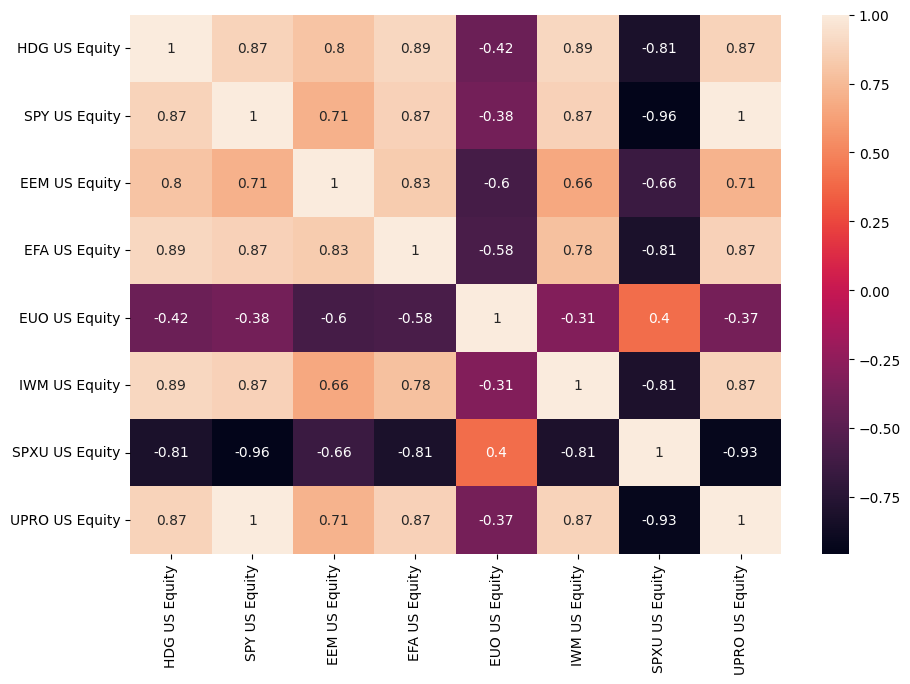

In [236]:
calc_correlations(etf_ex_hdg_returns)

### 6.

Explain how good is your replication, pointing out at least one good or bad argument related to each of the statistics mentioned in the bullet points above (thus, you should have at least 4 arguments).

*Answer:*
- Alpha is statically zero --> good
- Information ratio is high --> bad
- R-square is high (above 80%) --> good
- Correlation matrix concentraded --> bad


***

# 4. 

The data in sheet `fx carry excess returns` has **excess** daily returns for trading currencies.
* You **do NOT need** to know anything about FX, currency, or the underlying strategies.
* Rather, just take these return series as given.

For the problems below, we will **only use** the `JPY` series.

### 1.

Calculate the `1%` VaR as follows...

Empirical VaR:
* At every point in time, calculate the `1st` quantile of the returns up to that point.
* No need to scale the answers.
  
Report the VaR for the final date of the sample.

In [186]:
norm.ppf(0.25)

-0.6744897501960817

In [190]:
# Assuming first quantile as the first 25%, not 1% (first percentile)
jpy_returns = fx_carry_returns['JPY']
fx_carry_returns_var = calc_var_cvar_summary(jpy_returns, 
                                             window = 233, 
                                             percentile=0.25,
                                             expanding_min_window = 60,
                                             shift = 1,
                                             z_score=-2.33,
                                             ewma_theta = 0.94,
                                             return_stats=['var']).dropna()
fx_carry_returns_var.tail(3)

VaR and CVaR are given shifted by 1 period(s).


,Returns,Expanding Historical VaR (25%),Rolling 233 Historical VaR (25%),Expanding Volatility,Rolling 233 Volatility,EWMA 0.94 Volatility,Expanding Parametric VaR (-2.33),Rolling 233 Parametric VaR (-2.33),EWMA 0.94 Parametric VaR (-2.33),Expanding Historical CVaR (25%),Rolling 233 Historical CVaR (25%),Expanding Parametrical CVaR (25%),Rolling 233 Parametrical CVaR (25%),EWMA 0.94 Parametrical CVaR (25%)
date,,,,,,,,,,,,,,
2024-08-01,0.0183,-0.0032,-0.0034,0.0057,0.0057,0.0076,-0.0134,-0.0134,-0.0178,-0.0067,-0.0067,-0.0006,-0.0006,-0.0008
2024-08-02,0.0040,-0.0032,-0.0034,0.0057,0.0057,0.0075,-0.0134,-0.0134,-0.0174,-0.0067,-0.0067,-0.0006,-0.0006,-0.0008
2024-08-05,0.0192,-0.0032,-0.0034,0.0058,0.0059,0.0086,-0.0134,-0.0136,-0.0201,-0.0067,-0.0067,-0.0006,-0.0006,-0.0009


In [185]:
jpy_expanding_var = fx_carry_returns_var['Expanding Historical VaR (25%)']
print("JPY Expanding VaR (25%): {:.4%}".format(jpy_expanding_var.iloc[-1]))

JPY Expanding VaR (25%): -0.3163%


### 2.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* rolling volatility.
* using a window of `233` days.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [192]:
jpy_rolling_var = fx_carry_returns_var['Rolling 233 Parametric VaR (-2.33)']
print("JPY Rolling Normal VaR (-2.33): {:.4%}".format(jpy_rolling_var.iloc[-1]))

JPY Rolling Normal VaR (-2.33): -1.3631%


### 3.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* EWMA volatility
* using $\lambda = 0.94$.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [193]:
jpy_ewma_var = fx_carry_returns_var['EWMA 0.94 Parametric VaR (-2.33)']
print("JPY EWMA 0.94 Parametric VaR (-2.33): {:.4%}".format(jpy_ewma_var.iloc[-1]))

JPY EWMA 0.94 Parametric VaR (-2.33): -2.0140%


### 4.

Make a plot of the three timeseries of your VaR estimates.

Succinctly point out the pros / cons of these approaches.

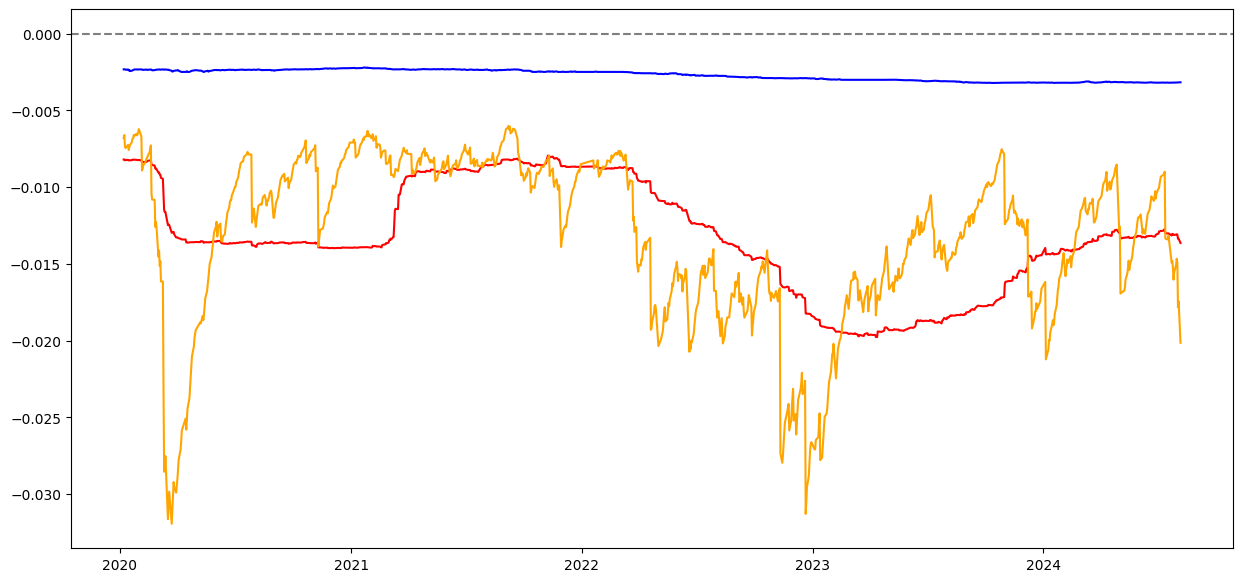

In [197]:

colors = ["blue", "red", "orange"]
plt.figure(figsize=(15, 7))
plt.axhline(y=0, linestyle='--', color='black', alpha=0.5)
plt.plot(
    jpy_expanding_var.index,
    jpy_expanding_var,
    color=colors[0],
    label=jpy_rolling_var.name
)
plt.plot(
    jpy_rolling_var.index,
    jpy_rolling_var,
    color=colors[1],
    label=jpy_rolling_var.name
)
plt.plot(
    jpy_ewma_var.index,
    jpy_ewma_var,
    color=colors[2],
    label=jpy_ewma_var.name
)

plt.show()

### 5.

What statistic do we use to judge the performance of a VaR model?

Estimate and report this statistic across the VaR methods.

Which VaR model do you find is best?

In [208]:
hit_ratios

,Hit Ratio,Hit Ratio Error,Hit Ratio Absolute Error
Rolling 233 Parametric VaR (-1.6448536269514729),0.0541,0.0821,0.0821
Expanding Parametric VaR (-1.6448536269514729),0.0588,0.1754,0.1754
EWMA 0.94 Parametric VaR (-1.6448536269514729),0.0597,0.1940,0.1940
Rolling 233 Historical VaR (5%),0.0616,0.2313,0.2313
Expanding Historical VaR (5%),0.0868,0.7351,0.7351


In [209]:
hit_ratios = calc_var_cvar_summary(jpy_returns, 
                    window = 233, 
                    percentile=0.25,
                    expanding_min_window = 60,
                    shift = 1,
                    z_score=-2.33,
                    ewma_theta = 0.94,
                    return_hit_ratio = True,
                    return_stats=['var']).dropna()
hit_ratios[hit_ratios.index.isin(['Expanding Historical VaR (25%)', 'Rolling 233 Parametric VaR (-2.33)', 'EWMA 0.94 Parametric VaR (-2.33)'])]

,Hit Ratio,Hit Ratio Error,Hit Ratio Absolute Error
Expanding Historical VaR (25%),0.2994,0.1978,0.1978
Rolling 233 Parametric VaR (-2.33),0.0252,-0.8993,0.8993
EWMA 0.94 Parametric VaR (-2.33),0.0224,-0.9104,0.9104


*Answer:*
- When we compare using the same percentile, we can see that 

***